In [12]:
# Load the latest data for analysis
import glob
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All packages imported successfully!")


All packages imported successfully!


In [13]:
latest = sorted(glob.glob("../data/processed/transactions_*.parquet"))[-1]
df = pd.read_parquet(latest)
df.shape, df['date'].min(), df['date'].max()

((4597, 4),
 Timestamp('2022-07-06 05:57:10+0000', tz='UTC'),
 Timestamp('2025-03-11 02:42:35+0000', tz='UTC'))

In [ ]:
# Cell 2 – Generate comprehensive EDA report as HTML
import base64
import io
from datetime import datetime

# Function to convert matplotlib plots to base64 string
def plot_to_base64(fig):
    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format='png', bbox_inches='tight', dpi=100)
    img_buffer.seek(0)
    img_base64 = base64.b64encode(img_buffer.getvalue()).decode()
    plt.close(fig)
    return img_base64

# Generate all plots and data for the report
print("Generating Transaction EDA Report...")

# Dataset overview
n_rows, n_cols = df.shape
missing_cells = df.isnull().sum().sum()
duplicate_rows = df.duplicated().sum()
memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # MB

# Generate distribution plots for numerical columns
plots_base64 = {}
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    if col != 'ingested_at':  # Skip ingested_at as it's a timestamp
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Histogram
        ax1.hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title(f'{col.title()} Distribution')
        ax1.set_xlabel(col.title())
        ax1.set_ylabel('Frequency')
        
        # Box plot
        ax2.boxplot(df[col])
        ax2.set_title(f'{col.title()} Box Plot')
        ax2.set_ylabel(col.title())
        
        plt.tight_layout()
        plots_base64[col] = plot_to_base64(fig)

# Category distribution plot
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    fig, ax = plt.subplots(figsize=(12, 6))
    value_counts = df[col].value_counts().head(15)
    bars = ax.bar(range(len(value_counts)), value_counts.values, color='coral')
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_title(f'Top 15 {col.title()} Distribution')
    ax.set_ylabel('Count')
    
    # Add value labels on bars
    for bar, value in zip(bars, value_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(value_counts.values),
                str(value), ha='center', va='bottom')
    
    plt.tight_layout()
    plots_base64[col] = plot_to_base64(fig)

# Time series plot
if 'date' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    df_daily = df.set_index('date').resample('D').size()
    ax.plot(df_daily.index, df_daily.values, color='green', linewidth=1.5)
    ax.set_title('Daily Transaction Count Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Transactions')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plots_base64['time_series'] = plot_to_base64(fig)

# Correlation matrix if multiple numerical columns
if len(numerical_cols) > 1:
    fig, ax = plt.subplots(figsize=(8, 6))
    # Only use amount column for correlation (skip ingested_at)
    corr_cols = [col for col in numerical_cols if col != 'ingested_at']
    if len(corr_cols) > 1:
        correlation_matrix = df[corr_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
        ax.set_title('Correlation Matrix')
        plt.tight_layout()
        plots_base64['correlation'] = plot_to_base64(fig)

# Generate HTML report
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Transaction EDA Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
        .container {{ max-width: 1200px; margin: 0 auto; background-color: white; padding: 30px; border-radius: 10px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }}
        h1 {{ color: #2c3e50; text-align: center; border-bottom: 3px solid #3498db; padding-bottom: 20px; }}
        h2 {{ color: #34495e; border-bottom: 2px solid #ecf0f1; padding-bottom: 10px; margin-top: 30px; }}
        h3 {{ color: #7f8c8d; }}
        .overview {{ background-color: #ecf0f1; padding: 20px; border-radius: 5px; margin: 20px 0; }}
        .stat-grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 15px; margin: 20px 0; }}
        .stat-item {{ background-color: #3498db; color: white; padding: 15px; border-radius: 5px; text-align: center; }}
        .stat-value {{ font-size: 24px; font-weight: bold; }}
        .stat-label {{ font-size: 14px; opacity: 0.9; }}
        table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
        .plot-container {{ text-align: center; margin: 30px 0; }}
        .plot-container img {{ max-width: 100%; border: 1px solid #ddd; border-radius: 5px; }}
        .alert {{ background-color: #e74c3c; color: white; padding: 15px; border-radius: 5px; margin: 20px 0; }}
        .success {{ background-color: #27ae60; color: white; padding: 15px; border-radius: 5px; margin: 20px 0; }}
        .warning {{ background-color: #f39c12; color: white; padding: 15px; border-radius: 5px; margin: 20px 0; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>Transaction EDA Report</h1>
        <p style="text-align: center; color: #7f8c8d;">Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        
        <div class="overview">
            <h2>Dataset Overview</h2>
            <div class="stat-grid">
                <div class="stat-item">
                    <div class="stat-value">{n_rows:,}</div>
                    <div class="stat-label">Rows</div>
                </div>
                <div class="stat-item">
                    <div class="stat-value">{n_cols}</div>
                    <div class="stat-label">Columns</div>
                </div>
                <div class="stat-item">
                    <div class="stat-value">{missing_cells}</div>
                    <div class="stat-label">Missing Cells</div>
                </div>
                <div class="stat-item">
                    <div class="stat-value">{duplicate_rows}</div>
                    <div class="stat-label">Duplicate Rows</div>
                </div>
                <div class="stat-item">
                    <div class="stat-value">{memory_usage:.1f} MB</div>
                    <div class="stat-label">Memory Usage</div>
                </div>
            </div>
        </div>
        
        <h2>Data Quality Assessment</h2>
        {'<div class="success">✅ No missing values detected</div>' if missing_cells == 0 else f'<div class="warning">⚠️ {missing_cells} missing values found</div>'}
        {'<div class="success">✅ No duplicate rows detected</div>' if duplicate_rows == 0 else f'<div class="alert">❌ {duplicate_rows} duplicate rows found</div>'}
        
        <h2>Variable Analysis</h2>
"""

# Add variable analysis for each column
for col in df.columns:
    if col == 'ingested_at':
        continue  # Skip technical timestamp column
        
    html_content += f"<h3>{col.title()}</h3>"
    
    if df[col].dtype == 'object':
        # Categorical variable
        unique_count = df[col].nunique()
        most_frequent = df[col].value_counts().index[0]
        most_frequent_count = df[col].value_counts().iloc[0]
        
        html_content += f"""
        <table>
            <tr><th>Property</th><th>Value</th></tr>
            <tr><td>Type</td><td>Categorical</td></tr>
            <tr><td>Unique Values</td><td>{unique_count}</td></tr>
            <tr><td>Most Frequent</td><td>{most_frequent} ({most_frequent_count} occurrences)</td></tr>
        </table>
        """
        
        if col in plots_base64:
            html_content += f"""
            <div class="plot-container">
                <img src="data:image/png;base64,{plots_base64[col]}" alt="{col} distribution">
            </div>
            """
            
    elif pd.api.types.is_numeric_dtype(df[col]):
        # Numerical variable
        stats = df[col].describe()
        
        html_content += f"""
        <table>
            <tr><th>Statistic</th><th>Value</th></tr>
            <tr><td>Count</td><td>{stats['count']:.0f}</td></tr>
            <tr><td>Mean</td><td>{stats['mean']:.2f}</td></tr>
            <tr><td>Std</td><td>{stats['std']:.2f}</td></tr>
            <tr><td>Min</td><td>{stats['min']:.2f}</td></tr>
            <tr><td>25%</td><td>{stats['25%']:.2f}</td></tr>
            <tr><td>50% (Median)</td><td>{stats['50%']:.2f}</td></tr>
            <tr><td>75%</td><td>{stats['75%']:.2f}</td></tr>
            <tr><td>Max</td><td>{stats['max']:.2f}</td></tr>
        </table>
        """
        
        if col in plots_base64:
            html_content += f"""
            <div class="plot-container">
                <img src="data:image/png;base64,{plots_base64[col]}" alt="{col} distribution">
            </div>
            """

# Add time series if available
if 'time_series' in plots_base64:
    html_content += f"""
    <h2>Time Series Analysis</h2>
    <div class="plot-container">
        <img src="data:image/png;base64,{plots_base64['time_series']}" alt="Time series">
    </div>
    """

# Add correlation matrix if available
if 'correlation' in plots_base64:
    html_content += f"""
    <h2>Correlations</h2>
    <div class="plot-container">
        <img src="data:image/png;base64,{plots_base64['correlation']}" alt="Correlation matrix">
    </div>
    """

# Add sample data
html_content += f"""
<h2>Sample Data</h2>
<table>
    <tr>
        {"".join([f"<th>{col}</th>" for col in df.columns if col != 'ingested_at'])}
    </tr>
"""

for idx, row in df.head(10).iterrows():
    html_content += "<tr>"
    for col in df.columns:
        if col != 'ingested_at':
            value = row[col]
            if pd.api.types.is_numeric_dtype(df[col]):
                html_content += f"<td>{value:.2f}</td>"
            else:
                html_content += f"<td>{value}</td>"
    html_content += "</tr>"

html_content += """
</table>

<footer style="text-align: center; margin-top: 50px; padding-top: 20px; border-top: 1px solid #ddd; color: #7f8c8d;">
    <p>Generated by Custom EDA Script</p>
</footer>

    </div>
</body>
</html>
"""

# Save the HTML report
output_path = "../docs/eda_2025-08-02.html"
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"✅ EDA report generated successfully!")
print(f"📊 Report saved to: {output_path}")
print(f"   - Analyzed {n_rows:,} rows across {n_cols} columns")
print(f"   - Generated {len(plots_base64)} visualizations")
print(f"   - File size: {len(html_content)/1024:.1f} KB")


=== TRANSACTION DATA EXPLORATORY DATA ANALYSIS ===
Dataset shape: (4597, 4)
Date range: 2022-07-06 05:57:10+00:00 to 2025-03-11 02:42:35+00:00

=== DATASET OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597 entries, 0 to 4596
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         4597 non-null   datetime64[ns, UTC]
 1   category     4597 non-null   object             
 2   amount       4597 non-null   float64            
 3   ingested_at  4597 non-null   datetime64[us]     
dtypes: datetime64[ns, UTC](1), datetime64[us](1), float64(1), object(1)
memory usage: 143.8+ KB
None

=== MISSING VALUES ===
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

=== BASIC STATISTICS ===
            amount                 ingested_at
count  4597.000000                        4597
mean     15.591100  2025-08-02 19:55:23.733852
min       0.050000  2025-08-02 19:55:

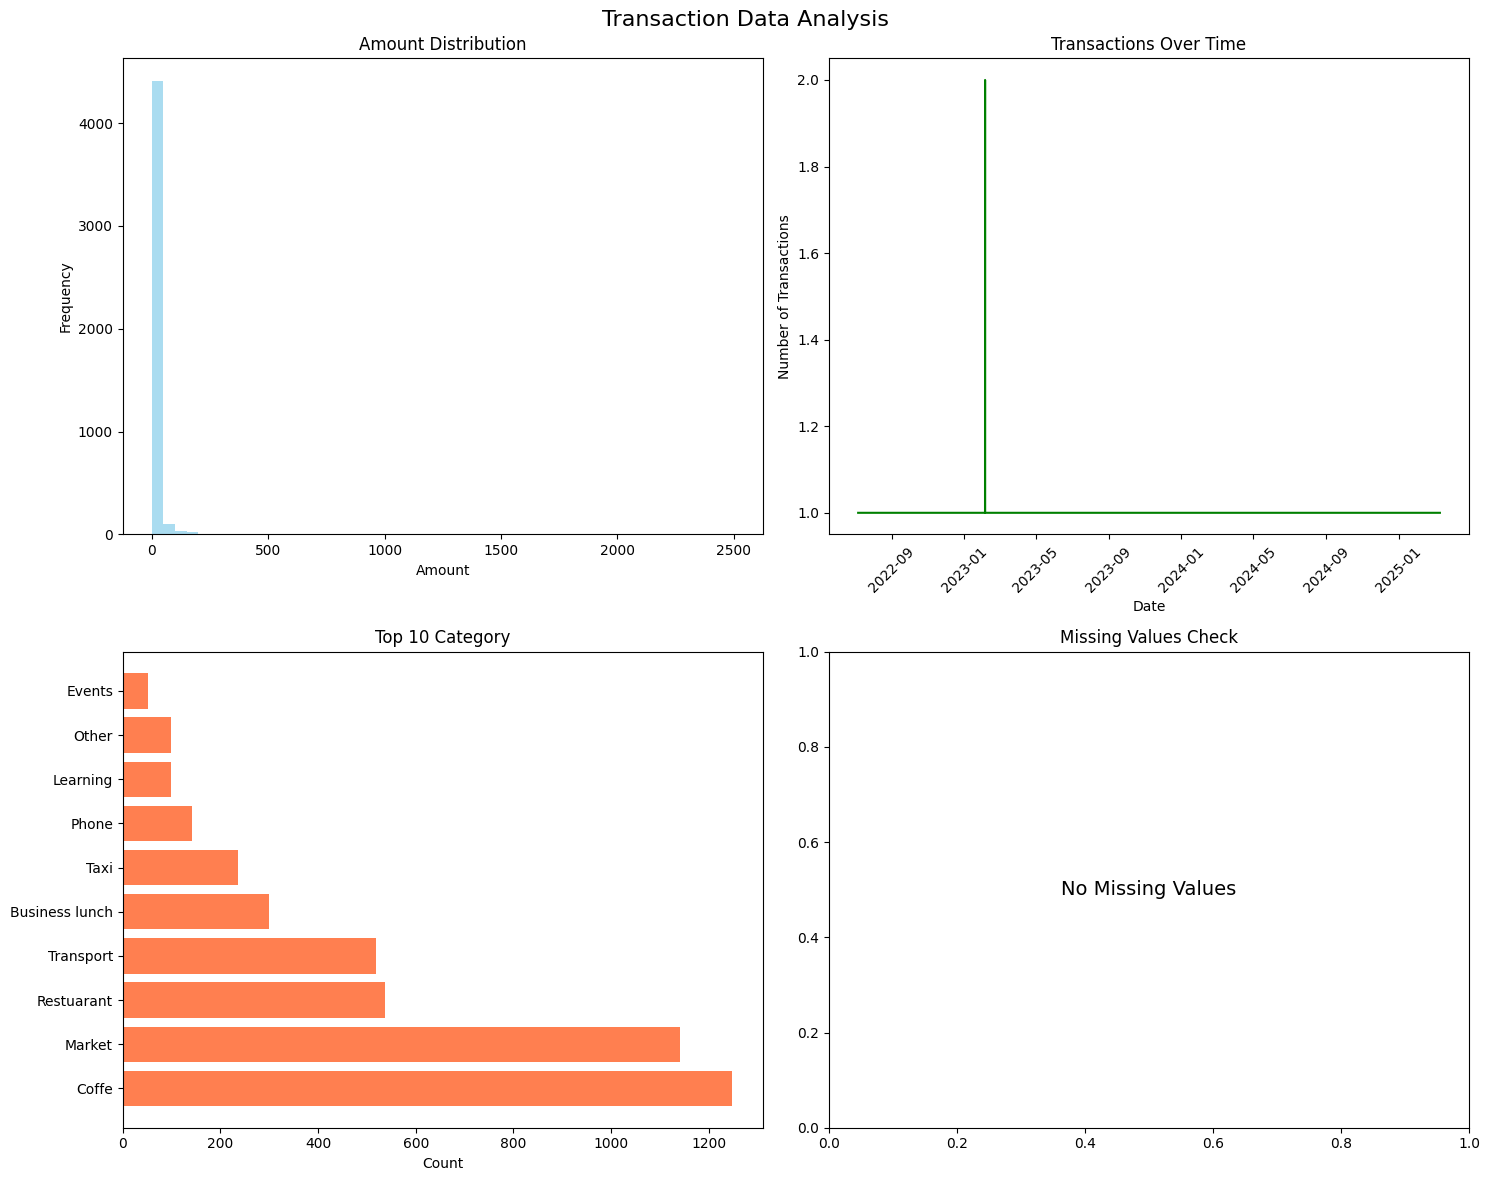

Visualizations completed!


In [15]:
# Cell 3 – Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Transaction Data Analysis', fontsize=16)

# 1. Amount distribution
if 'amount' in df.columns:
    axes[0, 0].hist(df['amount'], bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Amount Distribution')
    axes[0, 0].set_xlabel('Amount')
    axes[0, 0].set_ylabel('Frequency')

# 2. Transactions over time
if 'date' in df.columns:
    df_time = df.groupby('date').size()
    axes[0, 1].plot(df_time.index, df_time.values, color='green')
    axes[0, 1].set_title('Transactions Over Time')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Number of Transactions')
    axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Top categories (if category column exists)
cat_columns = df.select_dtypes(include=['object']).columns
if len(cat_columns) > 0:
    # Use the first categorical column
    cat_col = cat_columns[0]
    top_cats = df[cat_col].value_counts().head(10)
    axes[1, 0].barh(range(len(top_cats)), top_cats.values, color='coral')
    axes[1, 0].set_yticks(range(len(top_cats)))
    axes[1, 0].set_yticklabels(top_cats.index)
    axes[1, 0].set_title(f'Top 10 {cat_col.title()}')
    axes[1, 0].set_xlabel('Count')

# 4. Missing values heatmap
missing_df = df.isnull().sum()
if missing_df.sum() > 0:
    axes[1, 1].bar(range(len(missing_df)), missing_df.values, color='red', alpha=0.6)
    axes[1, 1].set_xticks(range(len(missing_df)))
    axes[1, 1].set_xticklabels(missing_df.index, rotation=45)
    axes[1, 1].set_title('Missing Values by Column')
    axes[1, 1].set_ylabel('Missing Count')
else:
    axes[1, 1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                    transform=axes[1, 1].transAxes, fontsize=14)
    axes[1, 1].set_title('Missing Values Check')

plt.tight_layout()
plt.show()

# Correlation matrix for numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
if len(numerical_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.show()

print("Visualizations completed!")
